In [ ]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive to access files
drive.mount('/content/drive')

# Navigate to the directory where the dataset is located in Google Drive
dataset_path = '/content/drive/MyDrive/your_dataset.zip'  # Replace with your path

# Unzip the dataset into a working directory
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Check extracted files
print("Extracted files:", os.listdir('/content/dataset'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files: ['your_dataset']


In [ ]:
#/train
#  /Normal
#  /OSCC
#/validation
#  /Normal
#  /OSCC
#/test
#  /Normal
#  /OSCC


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/traintestvald/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')
# Verify that both classes are being detected
print("Train classes:", train_generator.class_indices)


Found 5006 images belonging to 2 classes.
Train classes: {'Normal': 0, 'OSCC': 1}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator for validation and test sets
datagen = ImageDataGenerator(rescale=1./255)

# Validation data
validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/traintestvald/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')  # Make sure binary class mode is used for binary classification

# Test data
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/traintestvald/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# Verify that both classes are being detected
print("Validation classes:", validation_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Validation classes: {'Normal': 0, 'OSCC': 1}
Test classes: {'Normal': 0, 'OSCC': 1}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define the CNN model with binary classification
model = Sequential([
    # Input layer
    Input(shape=(128, 128, 3)),  # Define the input shape here

    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification (use sigmoid)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import Sequence

class PyDataset(Sequence):
    def __init__(self, data, labels, batch_size, **kwargs):
        super().__init__(**kwargs)  # Ensures proper initialization of the base class
        self.data = data
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_data, batch_labels



In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape separately
input_layer = Input(shape=(150, 150, 3))

# Define num_classes (should be 2 for binary classification)
num_classes = 2  # or the actual number of classes if it's more than 2

model = Sequential([
    input_layer,  # Add Input layer explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

# Compile the model here after it's defined
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # or categorical_crossentropy depending on num_classes

In [ ]:
# Train the model for 20 epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,                         # Set the number of epochs (adjust as needed)
    steps_per_epoch=train_generator.samples // 32,  # Number of steps per epoch
    validation_steps=validation_generator.samples // 32  # Validation steps
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 1015s 6s/step - accuracy: 0.5480 - loss: 1.1290 - val_accuracy: 0.6042 - val_loss: 0.6263
Epoch 2/20
  1/156 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5625 - loss: 0.7134

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.5625 - loss: 0.7134 - val_accuracy: 0.6250 - val_loss: 0.5613
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 512ms/step - accuracy: 0.6883 - loss: 0.5858 - val_accuracy: 0.7708 - val_loss: 0.4852
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7500 - loss: 0.4939 - val_accuracy: 0.7917 - val_loss: 0.5463
Epoch 5/20
 52/156 ━━━━━━━━━━━━━━━━━━━━ 49s 472ms/step - accuracy: 0.7580 - loss: 0.5035

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape separately
input_layer = Input(shape=(150, 150, 3))

# Define num_classes (should be 1 for binary classification with 'sigmoid' activation)
num_classes = 1

model = Sequential([
    input_layer,  # Add Input layer explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    # Output layer for binary classification (use sigmoid and num_classes=1)
    Dense(num_classes, activation='sigmoid')
])

# Compile the model here after it's defined
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape separately
input_layer = Input(shape=(150, 150, 3))

# Define num_classes (should be 2 for binary classification)
num_classes = 2  # or the actual number of classes if it's more than 2

model = Sequential([
    input_layer,  # Add Input layer explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    # Output layer for binary classification (use sigmoid and 1 unit)
    Dense(1, activation='sigmoid')
])

# Compile the model here after it's defined
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # or categorical_crossentropy depending on num_classes

In [ ]:
class_weight = {0: 1.0, 1: 3.0}  # Increase weight for minority class
history = model.fit(train_generator, validation_data=validation_generator, epochs=20, class_weight=class_weight)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 96s 571ms/step - accuracy: 0.9950 - loss: 0.0439 - val_accuracy: 0.8167 - val_loss: 1.2212
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.9969 - loss: 0.0277 - val_accuracy: 0.8000 - val_loss: 1.5067
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 488ms/step - accuracy: 0.9963 - loss: 0.0305 - val_accuracy: 0.8250 - val_loss: 1.0137
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 490ms/step - accuracy: 0.9964 - loss: 0.0244 - val_accuracy: 0.8083 - val_loss: 0.8211
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 486ms/step - accuracy: 0.9951 - loss: 0.0307 - val_accuracy: 0.7667 - val_loss: 1.1776
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 493ms/step - accuracy: 0.9957 - loss: 0.0360 - val_accuracy: 0.8083 - val_loss: 1.3954
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 499ms/step - accuracy: 0.9942 - loss: 0.0397 - val_accuracy: 0.8167 - val_loss: 1.1520
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 496ms/step - accuracy: 0.9935 - loss: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7921 - loss: 1.3982
Validation Loss: 1.3388149738311768
Validation Accuracy: 0.8083333373069763


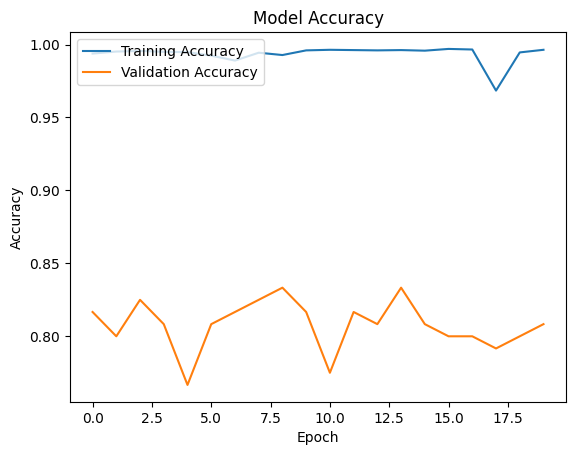

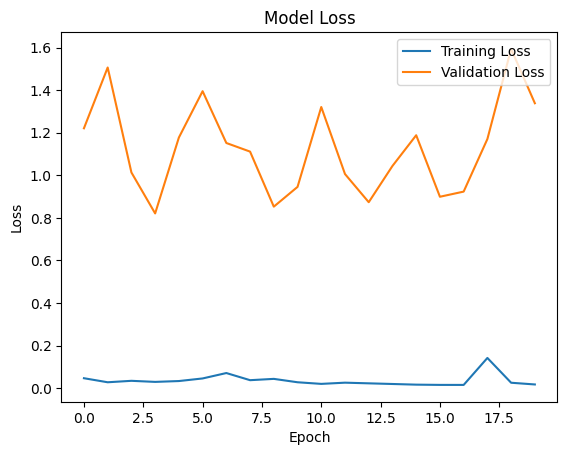

In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Plot the training history (optional)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
import pandas as pd

# Convert history to a DataFrame and save to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/Book1.csv', index=False)  # Save to a downloadable path

# Output downloadable file path
print("Training history saved as 'training_history.csv'")




NameError: name 'history' is not defined